In [295]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import scipy
from sklearn import preprocessing

%matplotlib inline

In [296]:
# # Get in dataset
# data_features_test = pd.read_csv("/home/knel/virtual_envs/ankh-morpork/ICS_data_generation/data/csvDataFeaturesTest.csv", sep=";")

# # Take out only data corresponing to attacks and remove the column labelling it as an attack
# data_features_attacks = data_features_test.to_numpy()[238279:, :-1]
# print(np.count_nonzero(np.isnan(data_features_attacks)))
# # Set negative values to 0
# data_features_attacks = np.where(data_features_attacks >= 0, data_features_attacks, 0)
# data_features_attacks = data_features_attacks.reshape((9999,21,1)).astype('float32')

In [297]:
attacks = pd.read_csv("/home/knel/virtual_envs/ankh-morpork/ICS_data_generation/data/wustl_attacks.csv", sep=",")

In [298]:
attacks = preprocessing.normalize(attacks.to_numpy()[:, 1:], norm="max", axis=0)

# swap sport to front
# attacks[:, [0, 1]] = attacks[:, [1, 0]]
# # swap dport to after sport
# attacks[:, [1, 2]] = attacks[:, [2, 1]]
# # swap protocols to after dport
# attacks[:, [2, 14]] = attacks[:, [14, 2]]

# column order now -> sport, dport, protocols, continuous (discrete, discrete, discrete, continuous)

In [299]:
# what is sequence length actually representing here
# time steps
seq_length = 10
batch_size = 64
features = attacks.shape[1]
latent_dim = 100

In [300]:
# shuffle prevents model from getting stuck in local minima when solving the loss function
# train_dataset = attacks[:20000]
train_dataset = (tf.data.Dataset.from_tensor_slices(attacks[:9984]).shuffle(10000).batch(batch_size))
# test_dataset = attacks[int(np.floor(attacks.shape[0]*3/4)):]
test_dataset = attacks[attacks.shape[0]-5000:]

In [301]:
def make_generator_model():
    model = tf.keras.Sequential()
    # LSTM hidden layer with 100 memory units
    model.add(tf.keras.layers.LSTM(200, input_shape = (seq_length, latent_dim), recurrent_dropout=0.4, return_sequences=True))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.LSTM(200, recurrent_dropout=0.4))
    model.add(tf.keras.layers.ReLU())
    # dropout layer with a probability of 20
    # model.add(tf.keras.layers.Dropout(0.2))
    # output dense (fully connected) layer
    model.add(tf.keras.layers.Dense(features, activation="sigmoid"))
    return model

In [302]:
generator = make_generator_model()
# what do we want to the generator to output? One packet at a time? One attack at a time?
# what to use as noise - what kind of dimension?
# BGAN does [batch_size x seq_length, features]
# LSTM expects sequences of the form [samples, time steps, features]
# noise = tf.random.normal((batch_size, seq_length, features))
# generated_data_untrained = generator(noise, training=False)
# generated_data_untrained.get_shape()

In [303]:
test_dataset[0]

array([9.26999725e-01, 1.22096395e-03, 2.92112950e-03, 0.00000000e+00,
       2.00240288e-04, 9.90982063e-05, 1.82572028e-04, 1.49047820e-06,
       4.07894737e-01, 4.07894737e-01, 5.00000000e-01, 5.00000000e-01,
       9.50118765e-04, 3.99361022e-04, 1.00000000e+00, 0.00000000e+00,
       2.00013161e-07, 3.91909959e-07, 9.99939920e-01, 3.91909959e-07,
       3.91909959e-07, 3.91909959e-07, 8.94117647e-01, 0.00000000e+00,
       0.00000000e+00, 3.91909959e-07, 0.00000000e+00])

In [304]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(200, input_shape=(features,1), recurrent_dropout=0.4, return_sequences=True))
    model.add(tf.keras.layers.LSTM(200, recurrent_dropout=0.4))
    # model.add(tf.keras.layers.Dropout(0.2))
    # what should the units of this dense layer be?
    # seems like it outputs one value >0 for real data and <0 for fake data
    # for each item in the batch
    model.add(tf.keras.layers.Dense(1, activation="tanh"))
    return model

In [305]:
discriminator = make_discriminator_model()
# decision_untrained = discriminator(generated_data_untrained)
# decision_untrained

### Binary Cross Entropy

$$ H_p(q) = -\frac{1}{N} \Sigma_{i=1}^N y_i log(p(y_i)) + (1-y_i) log(1-p(y_i)) $$

### BGAN Losses

$$ D_{loss} = \frac{1}{m} \Sigma_{i=1}^m [logD(x_i) + log(1-D(G(z_i)))] $$

$$ G_{loss} = \frac{1}{m} \Sigma_{i=1}^m [log(1-D(G(z_i)))] $$

In [306]:
# define losses (this will change)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False) # from_logits=True means models prediction represents a value [-inf, inf]

In [307]:
def discriminator_loss(real_data, fake_data):
    real_loss = cross_entropy(tf.ones_like(real_data), real_data)
    fake_loss = cross_entropy(tf.zeros_like(fake_data), fake_data)
    total_loss = real_loss + fake_loss
    return total_loss

    # BGAN loss
    # loss = tf.reduce_mean(tf.math.log(real_data) + tf.math.log(1 - fake_data))
    # # if tf.math.is_nan(loss):
    # #     return 0.0
    # return loss

In [308]:
d = discriminator(attacks[:64])
# tf.math.log(d), d

In [309]:
def generator_loss(fake_data):
    # return cross_entropy(tf.ones_like(fake_data), fake_data)

    # BGAN loss
    loss = tf.reduce_mean(tf.math.log(1 - fake_data))
    return loss

In [310]:
generator_optimiser = tf.keras.optimizers.Adam(1e-4)
discriminator_optimiser = tf.keras.optimizers.Adam(1e-4)

In [311]:
@tf.function
def train_step(data):
    dlosses = []
    glosses = []
    # generate samples from the random space
    noise = tf.random.normal((batch_size, seq_length, latent_dim))

    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_data = generator(noise, training=True)

        real_data = discriminator(data, training=True)
        fake_data = discriminator(generated_data, training=True)

        gloss = generator_loss(fake_data)
        dloss = discriminator_loss(real_data, fake_data)
        dlosses.append(dloss)
        glosses.append(gloss)

    generator_gradients = generator_tape.gradient(gloss, generator.trainable_variables)
    discriminator_gradients = discriminator_tape.gradient(dloss, discriminator.trainable_variables)

    generator_optimiser.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimiser.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    return dloss, gloss

In [312]:
epochs = 50

In [313]:
def train(dataset, epochs):
    dlosses = []
    glosses = []

    for epoch in range(epochs):
        
        # maybe add another loop for more training rounds
        for data_batch in dataset:
            dloss, gloss = train_step(data_batch)
        dlosses.append(dloss)
        glosses.append(gloss)

    return dlosses, glosses

In [314]:
# 33m to run 50 epochs with 20000 data points
dlosses, glosses = train(train_dataset, epochs=epochs)

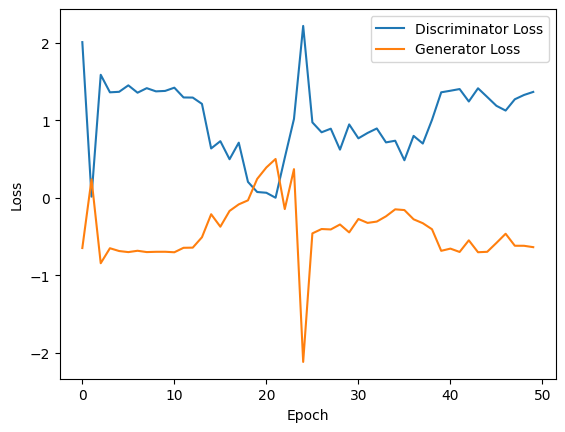

In [315]:
plt.plot(dlosses, label="Discriminator Loss")
plt.plot(glosses, label="Generator Loss")
# plt.ylim(-1,2)
# plt.xlim(0, 1000)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# plt.savefig("gan_lstm_wustl_network.png", dpi=800)

In [316]:
# when I increase memory units the losses go wild
# smoother losses using tanh for both activations and non-logit binary crossentropy
# not adding dropout genuinely makes it go insane

In [317]:
test_noise = tf.random.normal((test_dataset.shape[0], seq_length, latent_dim))
test_noise.shape
preds = generator.predict(test_noise)

157/157 [==============================] - 1s 4ms/step


In [318]:
# df = pd.DataFrame(preds)
# df.to_csv("gan_lstm_wustl_network.csv", index=False)

In [319]:
scipy.stats.ks_2samp(test_dataset.reshape(preds.shape[0]*features,), preds.reshape(preds.shape[0]*features,))

KstestResult(statistic=0.5889703703703704, pvalue=0.0, statistic_location=0.002923976562, statistic_sign=1)

In [320]:
preds[0], test_dataset[0]

(array([0.7712747 , 0.07182798, 0.14157419, 0.05549661, 0.07196659,
        0.0602718 , 0.09766856, 0.08216988, 0.11386082, 0.07393005,
        0.10134393, 0.0338176 , 0.02410534, 0.04401983, 0.25864643,
        0.16381666, 0.43957207, 0.30673504, 0.7092265 , 0.6778494 ,
        0.74138045, 0.6019765 , 0.5402644 , 0.23348372, 0.10797944,
        0.02850513, 0.016318  ], dtype=float32),
 array([9.26999725e-01, 1.22096395e-03, 2.92112950e-03, 0.00000000e+00,
        2.00240288e-04, 9.90982063e-05, 1.82572028e-04, 1.49047820e-06,
        4.07894737e-01, 4.07894737e-01, 5.00000000e-01, 5.00000000e-01,
        9.50118765e-04, 3.99361022e-04, 1.00000000e+00, 0.00000000e+00,
        2.00013161e-07, 3.91909959e-07, 9.99939920e-01, 3.91909959e-07,
        3.91909959e-07, 3.91909959e-07, 8.94117647e-01, 0.00000000e+00,
        0.00000000e+00, 3.91909959e-07, 0.00000000e+00]))